In [3]:
import cv2 as cv
import numpy as np
import os
import matplotlib.pyplot as plt

from copy import copy, deepcopy
from utils.classes import CellImage
from utils.helpers.helpers import get_images, show_images, show_plot_intensity_hists
from utils.helpers.enums import FilterAlg, ContoursDetectingAlg, MorphOperation, EdgesDetectingAlg, Pixel

In [4]:
subfolders = [f.path for f in os.scandir('./cells_images') if f.is_dir()]
folders_with_images = [[CellImage(image) for image in get_images(subfolder, limit=5)] for subfolder in subfolders]
for folder in folders_with_images:
    for image in folder:
        image.delete_description()
subfolders

['./cells_images/27_12_22_ps_v',
 './cells_images/28_12_22_ps_v',
 './cells_images/Provotorova',
 './cells_images/Provotorova_13.12.22']

In [157]:
def get_cells_using_sdb(image: CellImage):
    image.filter(alg=FilterAlg.GAUSSIAN)
    image.detect_contours(alg=ContoursDetectingAlg.OTSU_BINARIZATION)
    image.morph_transform(alg=MorphOperation.OPENING)
    image.morph_transform(alg=MorphOperation.CLOSING, kernel=np.ones((7, 7), np.uint8), iterations=2)
    image.morph_transform(alg=MorphOperation.EROSION, kernel=np.ones((9, 9), np.uint8), iterations=2)
    contours, _ = cv.findContours(image.src, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    params = cv.SimpleBlobDetector_Params()
    params.filterByInertia = True 
    params.filterByConvexity = True
    params.filterByCircularity = False
    params.filterByArea = True

    params.minArea = 2000
    params.maxArea = 100000
    params.minInertiaRatio = 0.1
    params.maxInertiaRatio = 0.8
    params.minConvexity = 0.01
    params.maxConvexity = 1

    noiseless_mask = np.full_like(image.src, 255)
    cv.fillPoly(noiseless_mask, contours, 0)
    detector = cv.SimpleBlobDetector_create(params)

    keypoints = detector.detect(noiseless_mask)
    cells_contours = []

    for keypoint in keypoints:
        x, y = tuple(map(int, keypoint.pt))
        for contour in contours:
            if cv.pointPolygonTest(contour, (x, y), False) > 0:
                cells_contours.append(contour)

    # noiseless mask
    image_rgb = cv.cvtColor(noiseless_mask, cv.COLOR_GRAY2RGB)
    
    for keypoint in keypoints:
        x, y = tuple(map(int, keypoint.pt))
        cv.circle(image_rgb, center=(x, y), radius=10, color=(0, 255, 0), thickness=-1)
        
    for contour in contours:
        if len(contour) > 4:    
            ((centx,centy), (width,height), angle) = cv.fitEllipse(contour)
            cv.ellipse(image_rgb, (int(centx),int(centy)), (int(width/2), int(height/2)), int(angle), 0, 360, (0,255,0), 5)

    return image_rgb

In [158]:
def show_images_with_their_masks(images: list[CellImage]):
    copied_images = deepcopy(images)
    originals = [(image.src, 'original') for image in copied_images]
    masks = [(get_cells_using_sdb(image), 'mask') for image in copied_images]
    show_images([
      *originals,
      *masks
    ], grid=(2, len(copied_images)), size_inches=(25, 8))

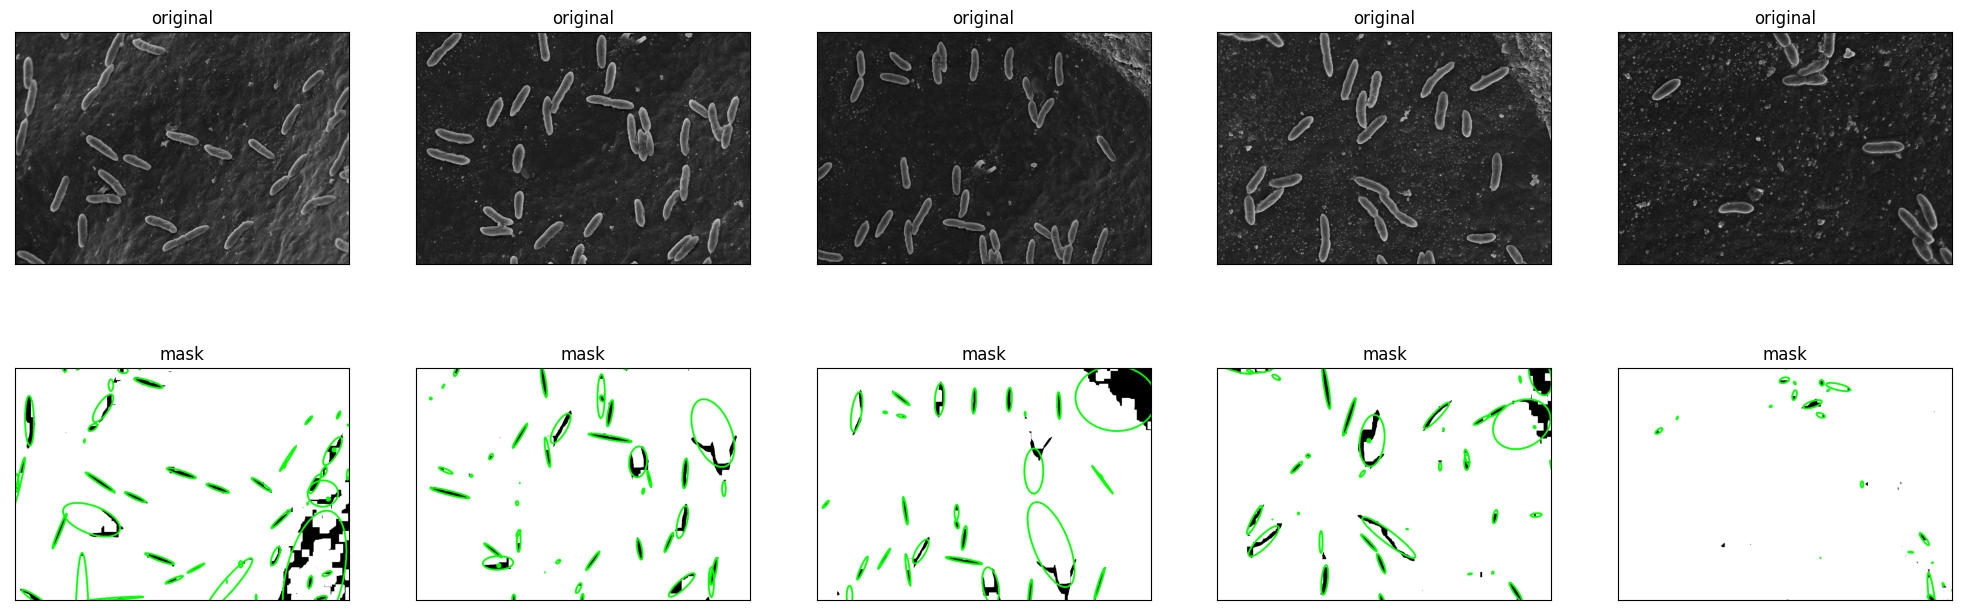

In [159]:
show_images_with_their_masks(folders_with_images[0])